# Object Detection using YOLO
YOLO(You Only Look Once) is an object detector that uses features learned by a deep convolutional neural network to detect an object. 

YOLO trained on the COCO dataset.The dataset consists of 80 labels, including, but not limited to:
People, <BR>
Bicycles, <BR>
Cars and trucks, <BR>
Airplanes, <BR>
Stop signs and fire hydrants, <BR>
Animals, including cats, dogs, birds, horses, cows, and sheep, and <BR>
Kitchen and dining objects, such as wine glasses, cups, forks, knives, spoons, etc. …and much more!

# Importing Resources

In [1]:
import cv2 #load our images
import matplotlib.pyplot as plt #plot them,

from utils import *  #module that contains some helper functions
from darknet import Darknet #modified version of *Darknet*. YOLO uses *Darknet*,an open source, deep neural network framework written by the creators of YOLO. 

# Setting Up The Neural Network

In [2]:
# Set the location and name of the cfg file that contains the network architecture
cfg_file = './cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file that contains the pre-trained weights
weight_file = './weights/yolov3.weights'

# Set the location and name of COCO object classes file that has the list of the 80 object classes that the weights were trained to detect.
namesfile = './data/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

# Taking a Look at The Neural Network

In [3]:
# Print the neural network used in YOLOv3
m.print_network()

layer filters size input output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x

As we can see, the neural network used by YOLOv3 consists mainly of convolutional layers, with some shortcut connections and upsample layers. For a full description of this network please refer to the <a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 Paper</a>.

# Loading and Resizing Our Images

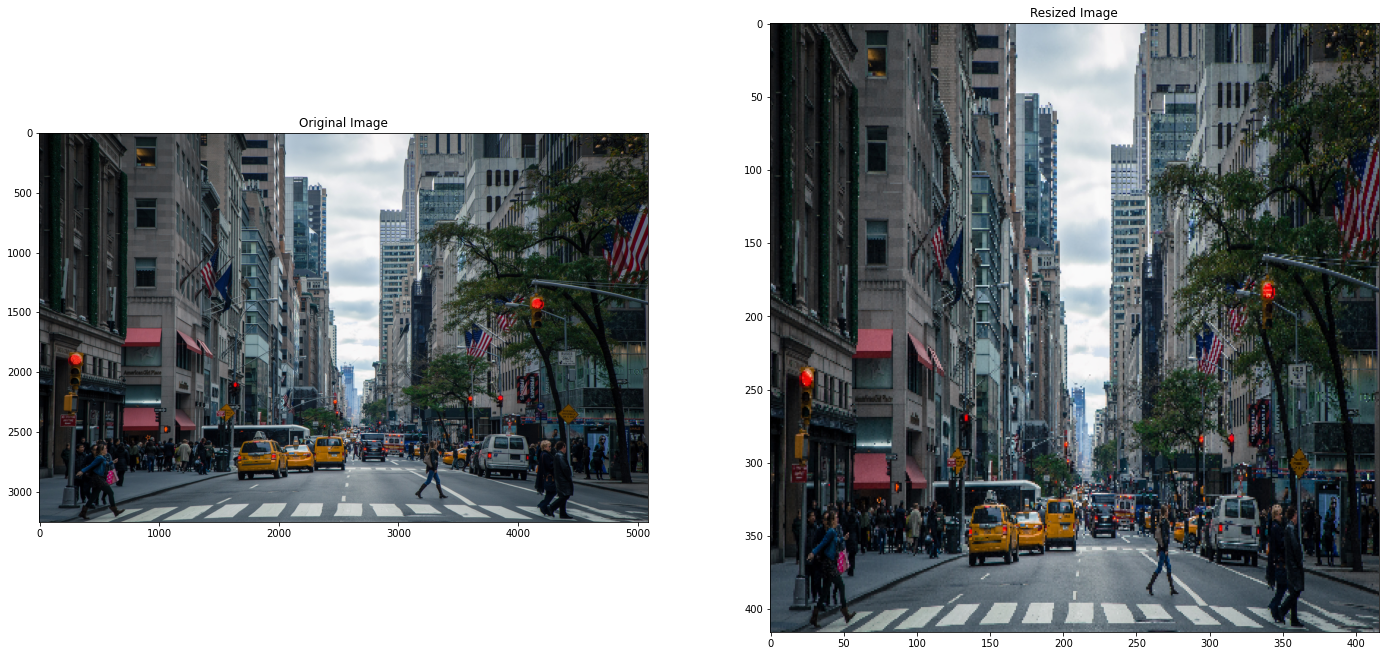

In [4]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# load our images using OpenCV's cv2.imread() function.
img = cv2.imread('./images/city_scene.jpg')

# #Since, this function loads images as BGR we will convert our images to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network ie 416 x 416 x 3.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# Setting the Non-Maximal Suppression (NMS) Threshold
 YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.  

In [5]:
# Set the NMS threshold
nms_thresh = 0.8

# Setting the Intersection Over Union (IOU) Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose **Intersection Over Union (IOU)** value is higher than a given IOU threshold.

In [6]:
# Set the IOU threshold
iou_thresh = 0.6

# Object Detection



It took 1.871 seconds to detect the objects in the image.

Number of Objects Detected: 17 

Objects Found and Confidence Level:

1. person: 0.999996
2. person: 1.000000
3. car: 0.707237
4. truck: 0.933031
5. car: 0.658084
6. truck: 0.666981
7. person: 1.000000
8. traffic light: 1.000000
9. person: 1.000000
10. car: 0.997369
11. bus: 0.998023
12. person: 1.000000
13. person: 1.000000
14. person: 1.000000
15. person: 1.000000
16. person: 0.999990
17. person: 1.000000


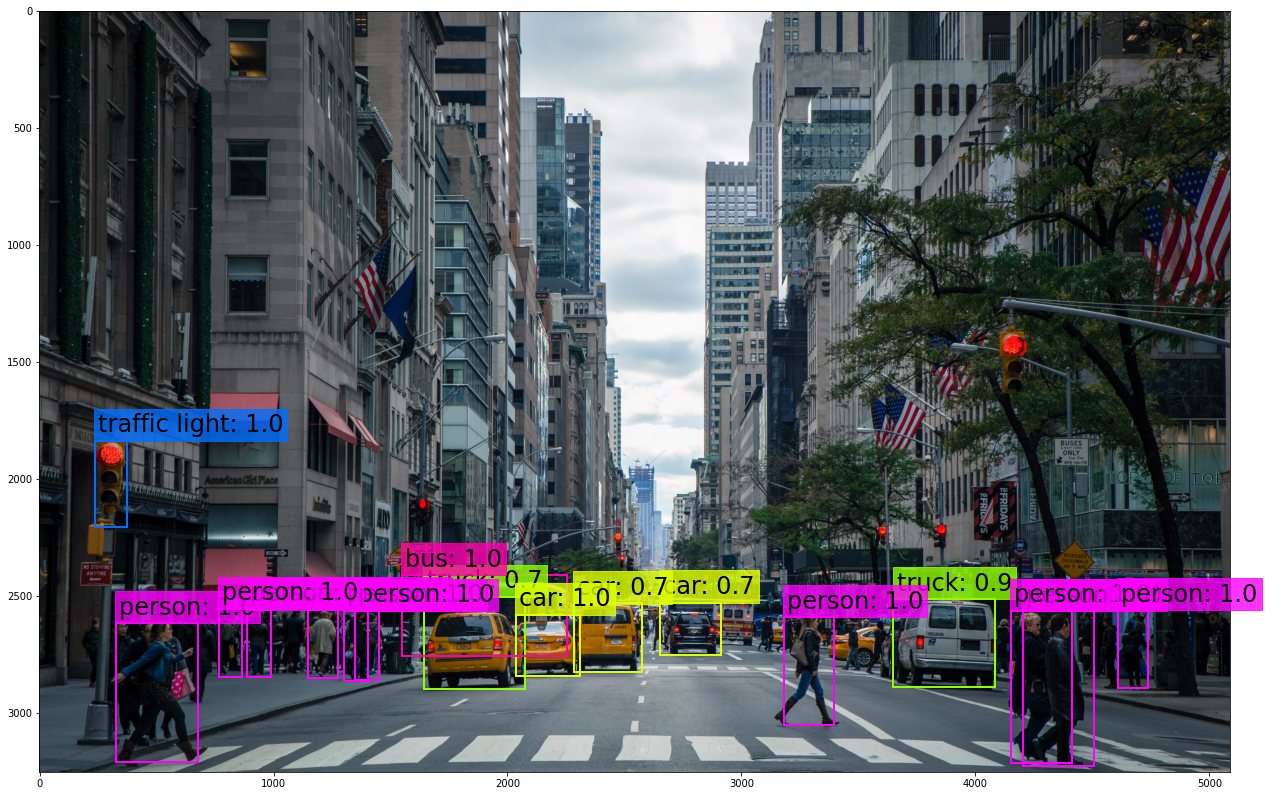

In [7]:
# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)